In [1]:
%matplotlib inline
import sys
import os
import numpy
import scipy
from matplotlib import pyplot
print os.getcwd()
sys.path.insert(0, '../')
from filter.filters import Filter, FilterFactory, truncate

/Users/maxiak/Documents/speakers/notebooks
Computing crc for ../filter/filters.py


In [2]:
ff = FilterFactory(48000, 1024)

Please close figure window to continue


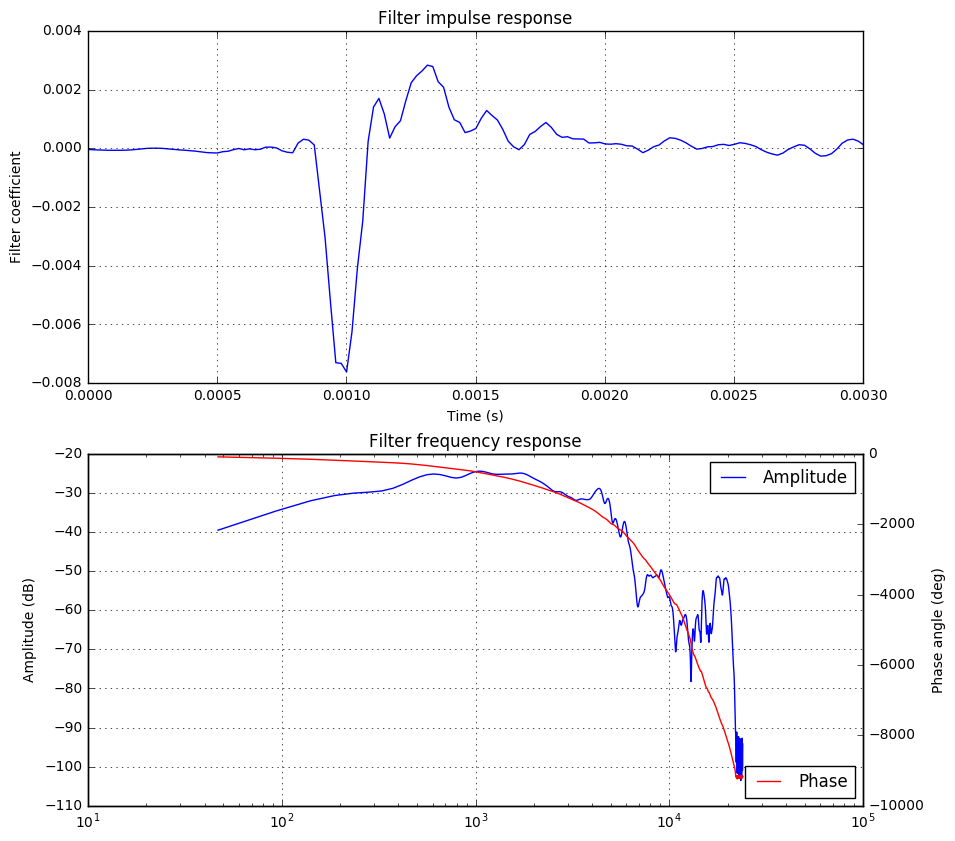

Please close figure window to continue


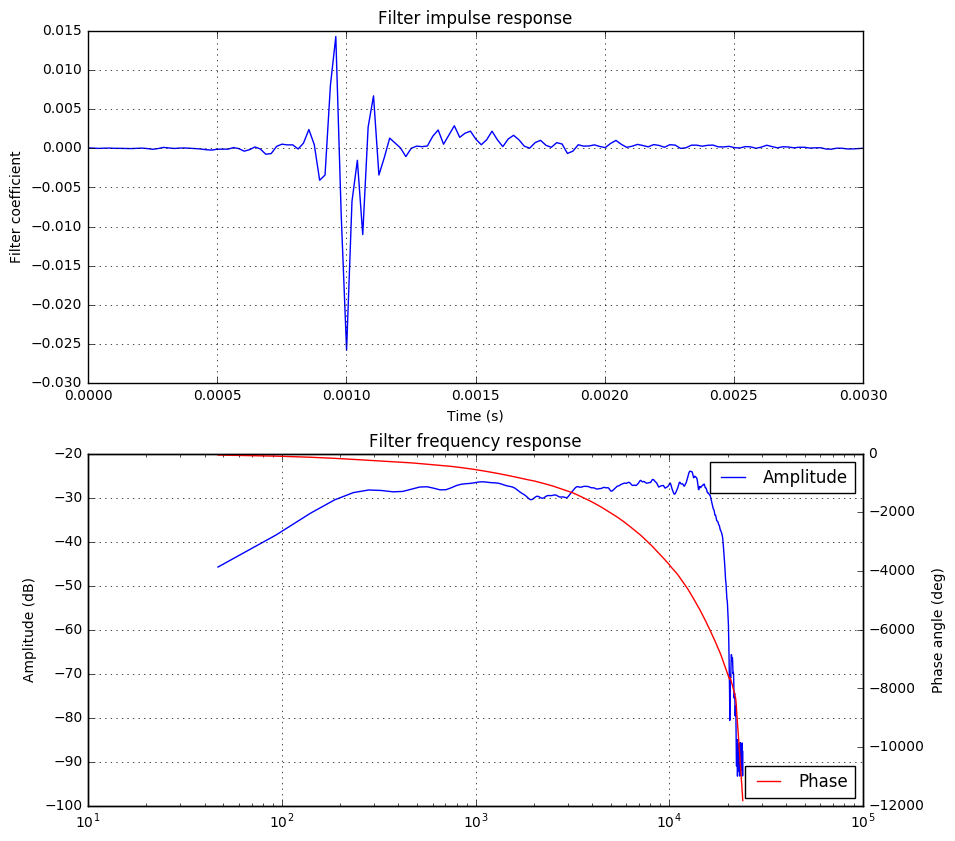

Please close figure window to continue


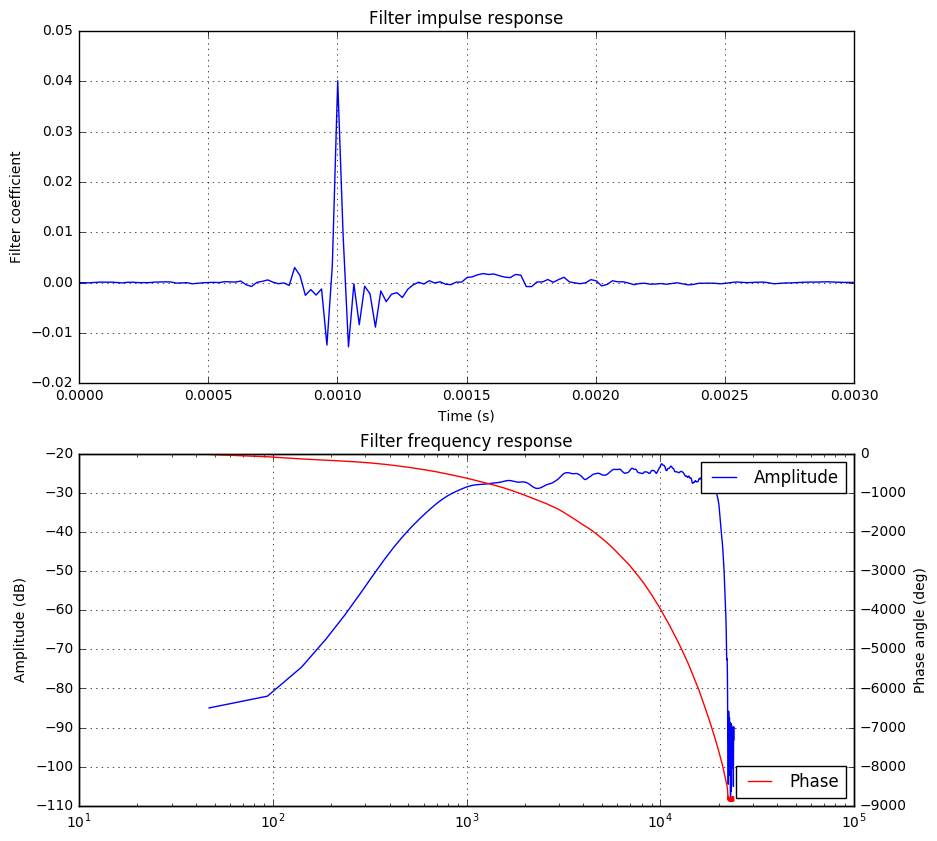

In [3]:
bass_driver = ff.measurement('../measurements/bassleft.txt.gz', (-.001, 0.0031))
mid_driver = ff.measurement('../measurements/midleft.txt.gz', (-.001, 0.0040))
tweeter_driver = ff.measurement('../measurements/tweeterleft.txt.gz', (-.001, 0.0040))
bass_driver.plot()
mid_driver.plot()
tweeter_driver.plot()

In [3]:

def plot_system(filters, plot_sum=True, title=None, plot_phase=True):
    filter_sum = ff.nopass()
    pyplot.figure(figsize=(12, 6))
    pyplot.hold(True)
    for filt in filters:
        filter_sum += filt
    if plot_sum:
        filters_aug = filters + [filter_sum,]
    else:
        filters_aug = filters
    peak_val = -9999

    freq_scales = []
    phases = []
    for filt in filters_aug:
        filter_size = len(filt.coefficients)
        fft_coefs = scipy.fftpack.fft(filt.coefficients)
        freq_scale = numpy.linspace(0, filt.sample_freq, filter_size + 1)[:-1]
        fft_coefs = fft_coefs[:(filter_size / 2 + 1)]
        freq_scale = freq_scale[:(filter_size) / 2 + 1]
        freq_scales.append(freq_scale)
        phases.append((180 / numpy.pi * numpy.unwrap(numpy.angle(fft_coefs))) % 360)
        fr_mag = 20 * numpy.log10(numpy.abs(fft_coefs))
        pyplot.semilogx(freq_scale, fr_mag)
        peak_val = max(peak_val, numpy.max(fr_mag))
    pyplot.grid(True)
    pyplot.ylim(peak_val - 20, peak_val + 3)
    if title is not None:
        pyplot.title(title + " Ampl")
    pyplot.show()

    if not plot_phase:
        return
    pyplot.figure(figsize=(12, 6))
    pyplot.hold(True)

    for freq_scale, phase in zip(freq_scales, phases):
        pyplot.semilogx(freq_scale, phase)
    pyplot.grid(True)
    pyplot.ylim(0, 360)
    if title is not None:
        pyplot.title(title + " Phase")
    pyplot.show()

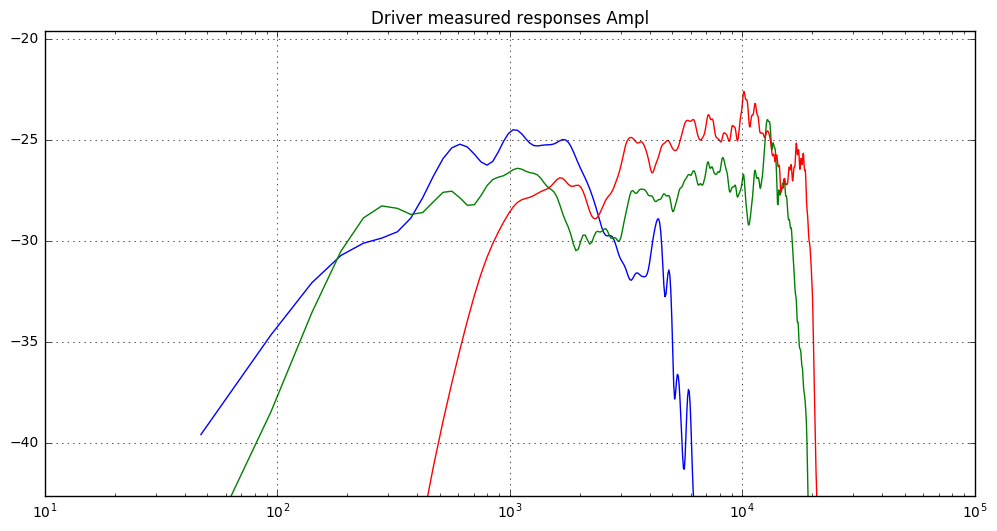

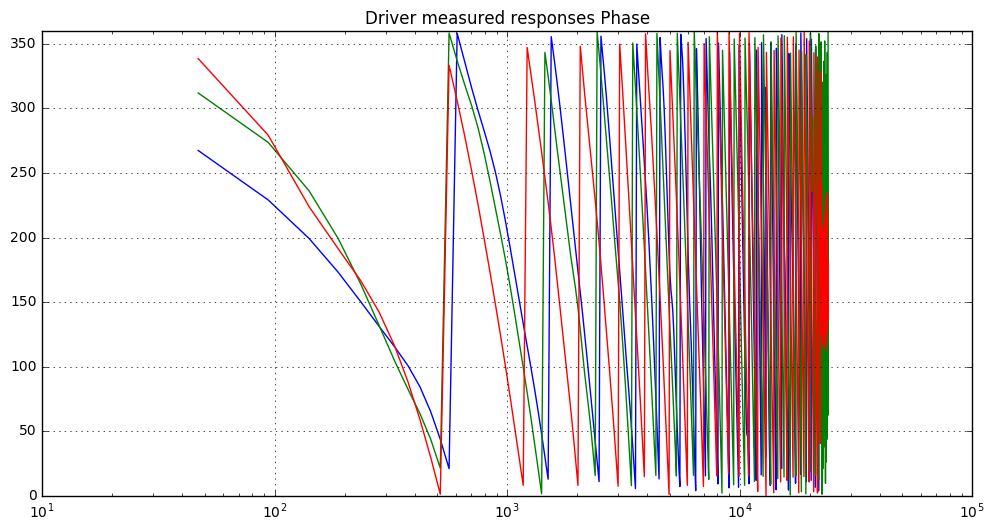

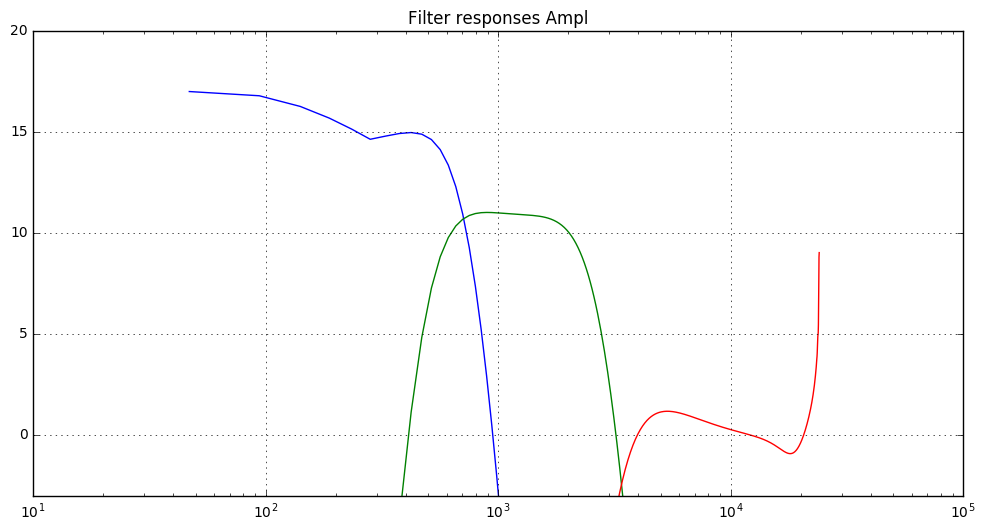

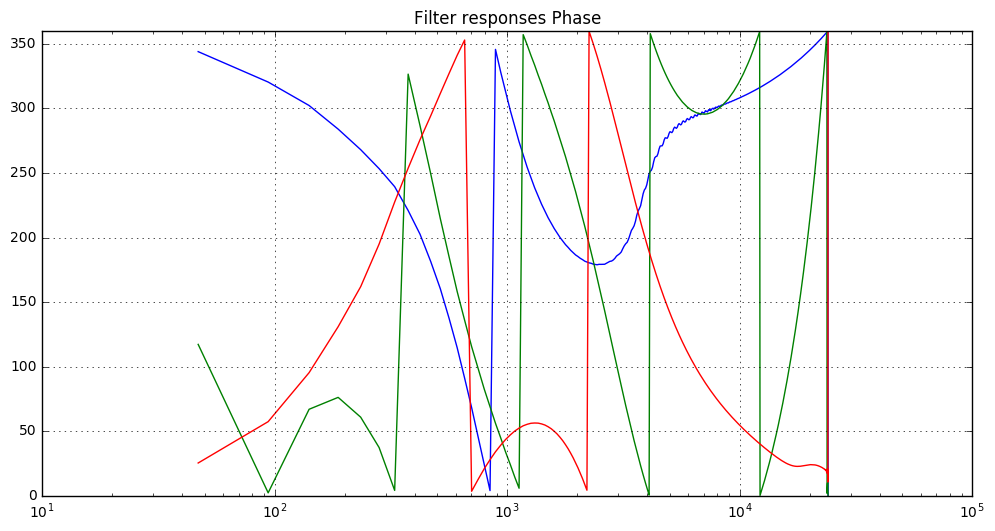

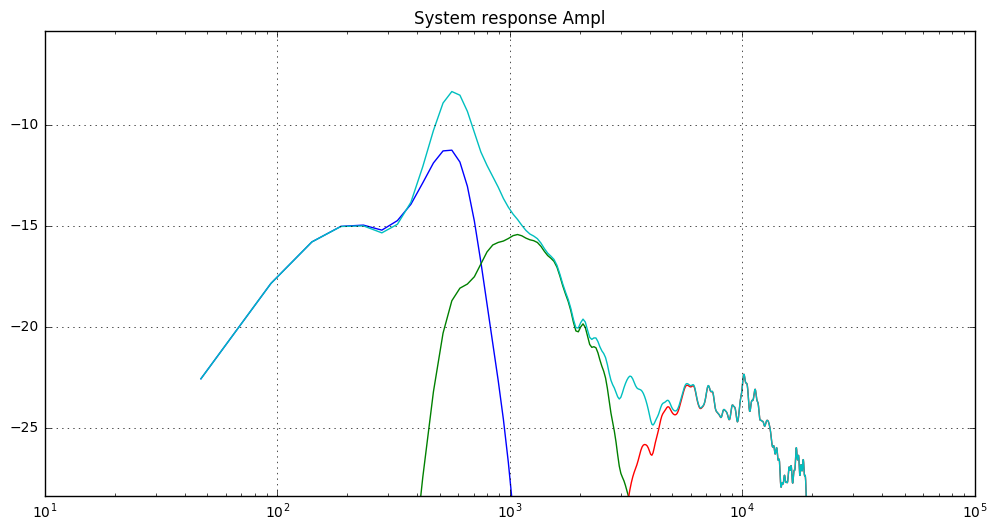

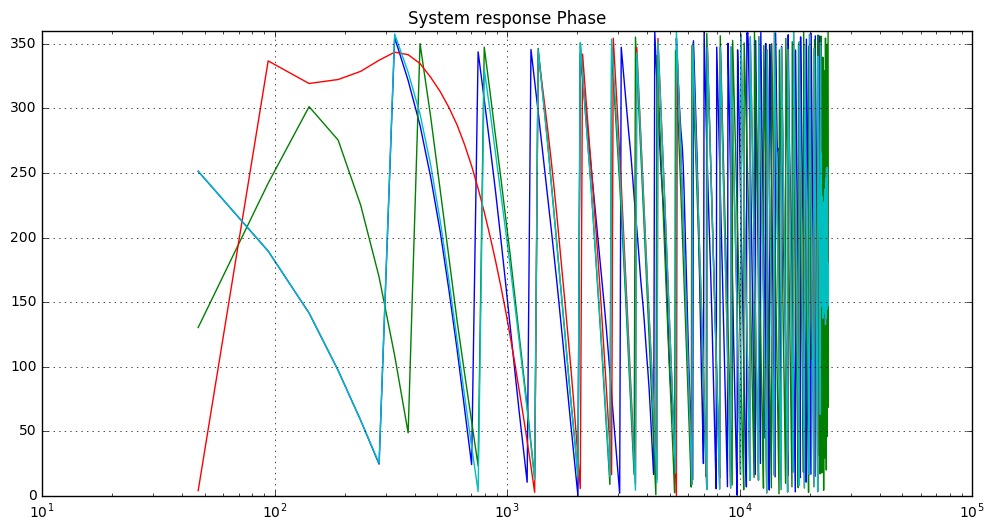

In [5]:
def x():
    ff = filter_factory = FilterFactory(sample_freq=48000, filter_size=1024)

    #   EQ will compensate for baffle effects
    #   Use the shelving filter for baffle step compensation only outside the EQ band
    meas_lf_cutoff = 300
    baffle_step = ff.apply_freq_limits(ff.shelf(450, -10), 0, meas_lf_cutoff)

    RT2 = 0.707 ** .5

    mid_hp = ff.analog_hp2(450, RT2) ** 4
    mid_lp = ff.analog_lp2(3000, RT2) ** 4
    mid_bp = mid_hp * mid_lp

    tw_eq = ff.parametric_eq(1.9e4, 2, -2)
    mid_eq = ff.parametric_eq(300, 0.707, 1)
    wf_eq = ff.parametric_eq(75, .35, 1)

    crossover = [
        wf_eq * (ff.analog_lp2(800, RT2) ** 4) * baffle_step,
        mid_eq * mid_bp * baffle_step * ff.gain(-5.0),
        tw_eq * (ff.analog_hp2(3000, RT2) ** 4) * baffle_step * ff.invert() * ff.gain(-4),
    ]
    
    
    wf_driver = ff.measurement('../measurements/bassleft.txt.gz', (-.001, 0.0031))
    mid_driver = ff.measurement('../measurements/midleft.txt.gz', (-.001, 0.0040))
    tw_driver = ff.measurement('../measurements/tweeterleft.txt.gz', (-.001, 0.0040))

    wf_comp, mid_comp, tw_comp = [ff.invert(driver) for driver in (wf_driver, mid_driver, tw_driver)]

    crossover = [
        ff.min_phase(wf_comp * crossover[0]),
        ff.min_phase(mid_comp * crossover[1]),
        ff.min_phase(tw_comp  * crossover[2])
    ]
    return crossover

crossover = x()

wf_driver = ff.measurement('../measurements/bassleft.txt.gz', (-.001, 0.0031))
mid_driver = ff.measurement('../measurements/midleft.txt.gz', (-.001, 0.0040))
tw_driver = ff.measurement('../measurements/tweeterleft.txt.gz', (-.001, 0.0040))

system = [
    crossover[0] * wf_driver,
    crossover[1] * mid_driver,
    crossover[2] * tw_driver
]

meas_only = [wf_driver, mid_driver, tw_driver]

plot_system(meas_only, plot_sum=False, title='Driver measured responses')
plot_system(crossover, plot_sum=False, title='Filter responses')
plot_system(system, title='System response')


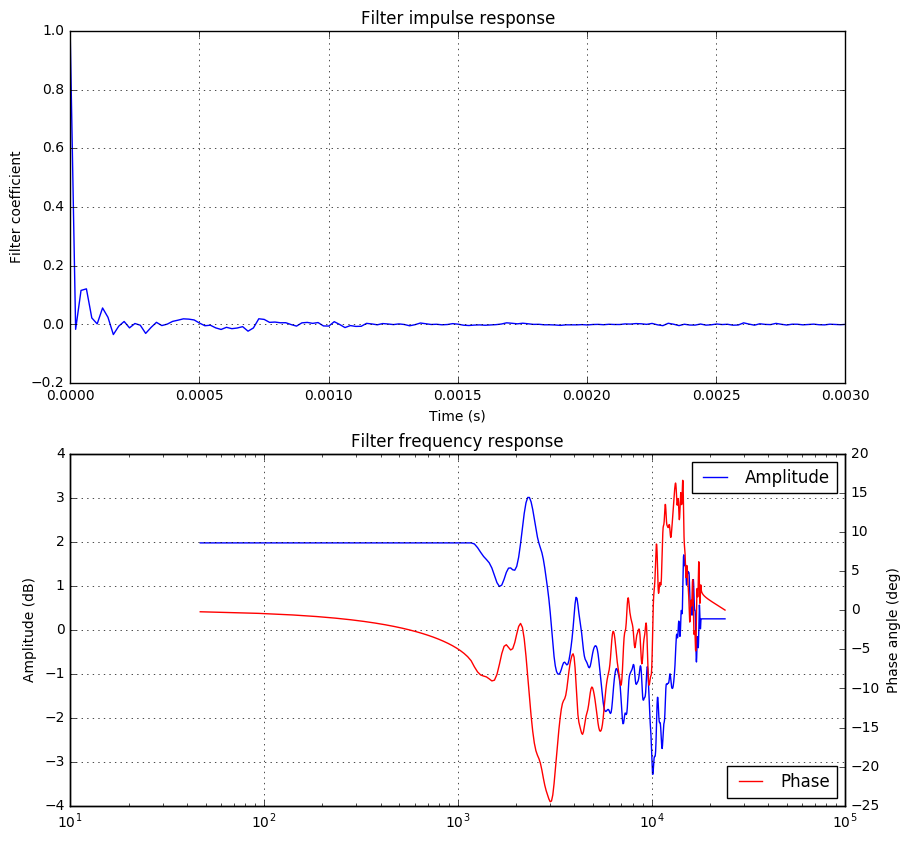

<invert_measurement filter for 48000hz sample freq with 1024 taps>

In [9]:
tw_comp = ff.invert_measurement('../measurements/tweeterleft.txt.gz', (-1e-3, 4e-3), (1.2e3, 1.8e4), nocache=True)
tw_comp

/Users/maxiak/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


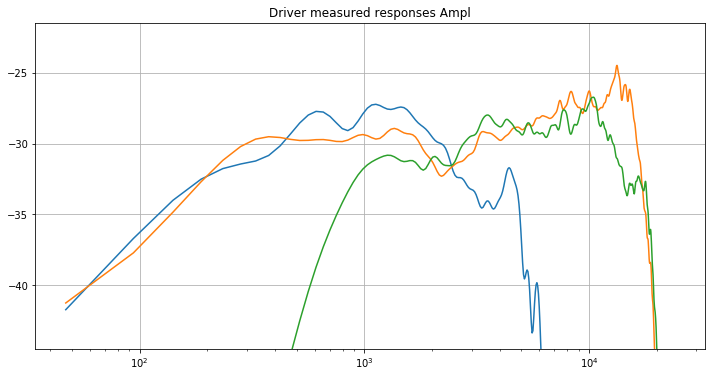

/Users/maxiak/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


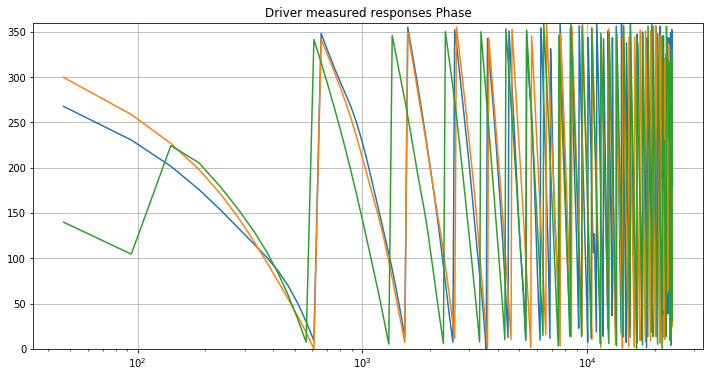

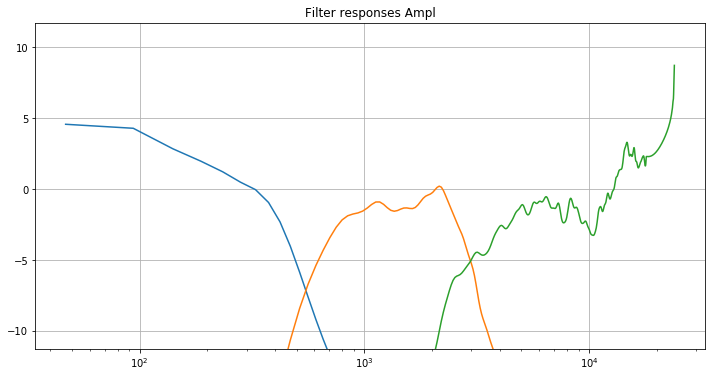

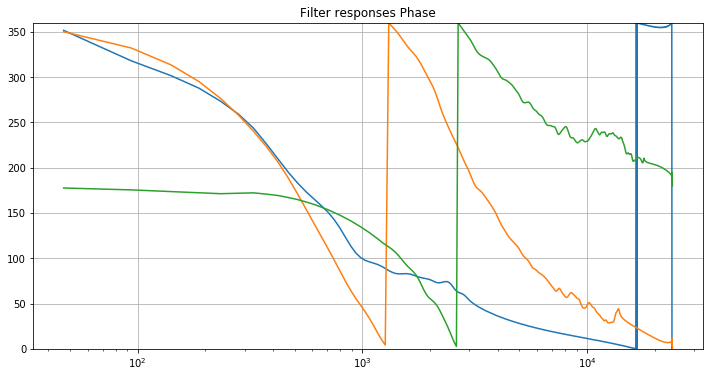

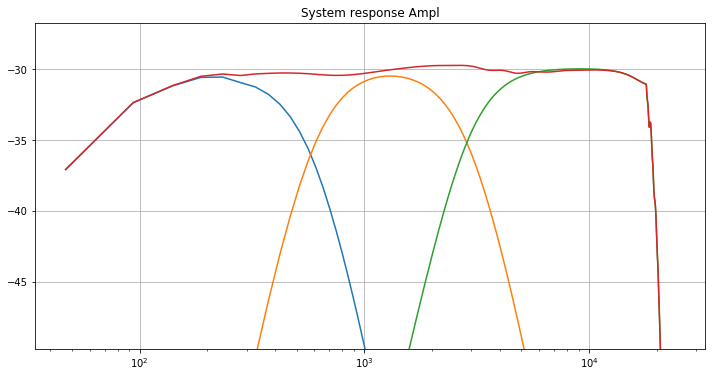

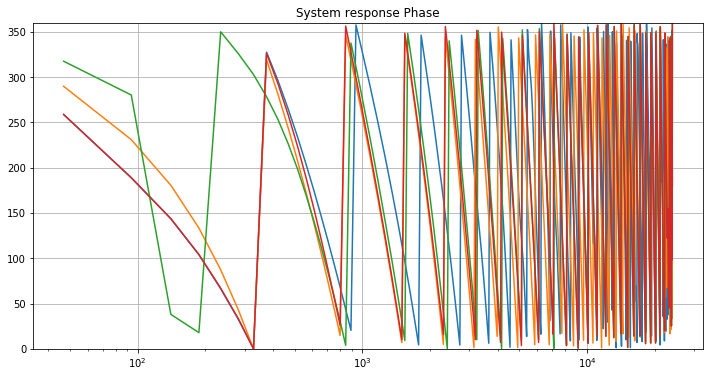

In [29]:
def x():
    #   EQ will compensate for baffle effects
    #   Use the shelving filter for baffle step compensation only outside the EQ band
    meas_lf_cutoff = 300
    baffle_step = ff.apply_freq_limits(ff.shelf(450, -6), 0, meas_lf_cutoff)
    tw_comp = ff.min_phase(ff.invert_measurement('../measurements/tweeterleft4.txt.gz', (-1e-3, 3.2e-3), (1.2e3, 1.8e4), nocache=True))
    mid_comp = ff.min_phase(ff.invert_measurement('../measurements/midleft4.txt.gz', (-1e-3, 3.1e-3), (meas_lf_cutoff, 1.4e4), nocache=True))
    wf_comp = ff.min_phase(ff.invert_measurement('../measurements/wooferleft4.txt.gz', (-1e-3, 2.5e-3), (meas_lf_cutoff, 3e3), nocache=True))

    RT2 = 0.707

    mid_hp = ff.analog_hp2(600, RT2) ** 2
    mid_lp = ff.analog_lp2(3000, RT2) ** 2
    mid_bp = mid_hp * mid_lp

    tw_eq = ff.parametric_eq(1.9e4, 2, -2) * ff.parametric_eq(2.9e3, 1, .5)
    
    mid_eq = ff.parametric_eq(300, 0.707, 1)
    wf_eq = ff.parametric_eq(65, 1, 3)

    tw_comp *= tw_eq
    mid_comp *= mid_eq
    wf_comp *= wf_eq

    crossover = [
        wf_comp * (ff.analog_lp2(600, RT2) ** 2) * baffle_step * ff.gain(4),
        mid_comp * mid_bp * baffle_step * ff.gain(-.2),
        tw_comp * (ff.analog_hp2(2900, RT2) ** 2) * baffle_step * ff.invert() * ff.gain(4),
    ]
    return crossover

crossover = x()


bass_driver = ff.measurement('../measurements/wooferleft4.txt.gz', (-.001, 0.0025))
mid_driver = ff.measurement('../measurements/midleft4.txt.gz', (-.001, 0.0031))
tweeter_driver = ff.measurement('../measurements/tweeterleft4.txt.gz', (-.001, 0.0032))

system = [
    crossover[0] * bass_driver,
    crossover[1] * mid_driver,
    crossover[2] * tweeter_driver
]


meas_only = [bass_driver, mid_driver, tweeter_driver]

plot_system(meas_only, plot_sum=False, title='Driver measured responses')
plot_system(crossover, plot_sum=False, title='Filter responses')
plot_system(system, title='System response')
